# SEMANTIC SEARCH ENGINE : IMANE ELBACHA

### Imports


In [1]:
import numpy as np 
import pandas as pd 
import spacy
import string
import gensim
import operator
import re
import warnings
from operator import itemgetter
warnings.filterwarnings('ignore')

## Data Pre_Processing 

In order to test the code we're gonna use the text conversiations given in the technical assignement:

In [2]:
data=pd.DataFrame([['We are seeing an increasing number of errors with our payment services. The issue has been reported by multiple users in the last 3 hours and this is affecting our revenue. We need to fix it immediately.'],
                  ['We need to make improvements to our landing page to convey our newbranding guidelines.'],
                 ['It looks like the issue is limited only to visa credit cards.'],
                 ['We need to schedule a product meeting to discuss the new set of features and the roadmap.']])

In [3]:
data

,0
0,We are seeing an increasing number of errors w...
1,We need to make improvements to our landing pa...
2,It looks like the issue is limited only to vis...
3,We need to schedule a product meeting to discu...


### DATA Pre_Processing: 

As explained in the document I sent before [TA_elbacha](https://drive.google.com/file/d/12cbESH85kTaOPDYcCBQmjBox4_RtKkBO/view?usp=sharing), Data processing is an important step in text analytics. The purpose is to remove any unwanted words or characters which are written for human readability, but won’t contribute to topic modeling. These are the elemnts to take into account in data cleaning


In [17]:
from spacy.lang.en.stop_words import STOP_WORDS

spacy_nlp = spacy.load('en_core_web_sm')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS


def cleaning_tokenizing(sentence):
    '''
    Function for data processing and cleaning :
    -removes unwanted characheters and stopwords
    -tokenizes the sentences 
    -lemmatize the tokens
    '''
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits and words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens

#### Test on data 

In [18]:
print ('Cleaning and Tokenizing...')
%time data['tokens'] = data[0].map(lambda x: cleaning_tokenizing(x))

data

Cleaning and Tokenizing...
CPU times: user 52.4 ms, sys: 3.34 ms, total: 55.7 ms
Wall time: 56.7 ms


,0,tokens
0,We are seeing an increasing number of errors w...,"[increase, number, error, payment, service, is..."
1,We need to make improvements to our landing pa...,"[need, improvement, landing, page, convey, new..."
2,It looks like the issue is limited only to vis...,"[look, like, issue, limit, visa, credit, card]"
3,We need to schedule a product meeting to discu...,"[need, schedule, product, meeting, discuss, ne..."


#### VISUALISITION 

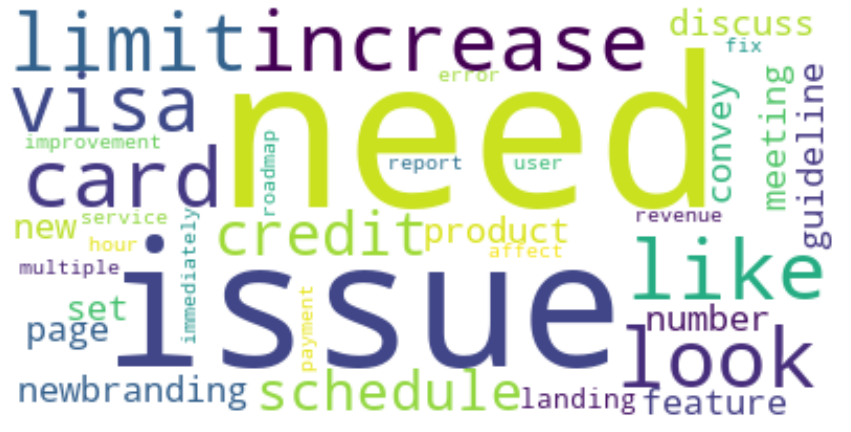

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(data['tokens'])).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Building Vocabulary

### Main topics

After experimenting with different models we are going to use the LDA model that unconvers different link within the structure of the documents giving a wider view of the suggested topics.

In [20]:
from gensim import corpora, models


dictionary = corpora.Dictionary(data['tokens'])

corpus = [dictionary.doc2bow(list_of_tokens) for list_of_tokens in data['tokens']]

num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary.keys()))

for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

CPU times: user 20.2 ms, sys: 2.19 ms, total: 22.4 ms
Wall time: 21.1 ms
0: 0.029*"visa" + 0.029*"discuss" + 0.029*"page" + 0.029*"card" + 0.029*"credit" + 0.029*"like" + 0.029*"limit" + 0.029*"look" + 0.029*"landing" + 0.029*"new"

1: 0.029*"visa" + 0.029*"discuss" + 0.029*"page" + 0.029*"card" + 0.029*"credit" + 0.029*"like" + 0.029*"limit" + 0.029*"look" + 0.029*"landing" + 0.029*"new"

2: 0.029*"visa" + 0.029*"discuss" + 0.029*"page" + 0.029*"card" + 0.029*"credit" + 0.029*"like" + 0.029*"limit" + 0.029*"look" + 0.029*"landing" + 0.029*"new"

3: 0.029*"visa" + 0.029*"discuss" + 0.029*"page" + 0.029*"card" + 0.029*"credit" + 0.029*"like" + 0.029*"limit" + 0.029*"look" + 0.029*"landing" + 0.029*"new"

4: 0.108*"need" + 0.108*"meeting" + 0.108*"new" + 0.108*"schedule" + 0.108*"roadmap" + 0.108*"set" + 0.108*"product" + 0.108*"feature" + 0.108*"discuss" + 0.001*"like"

5: 0.029*"visa" + 0.029*"discuss" + 0.029*"page" + 0.029*"card" + 0.029*"credit" + 0.029*"like" + 0.029*"limit" + 0.02

### Feature extraction

The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity. The output is  xed-length vectors with the count how many times each word appears. The doc2bow method, iterates through all the words in the text, if the word already exists in the corpus, it increments the frequency count, other wise it inserts the word into the corpus and sets it frequency count to 1.

In [21]:
word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus]

print(word_frequencies)

[[('affect', 1), ('error', 1), ('fix', 1), ('hour', 1), ('immediately', 1), ('increase', 1), ('issue', 1), ('multiple', 1), ('need', 1), ('number', 1), ('payment', 1), ('report', 1), ('revenue', 1), ('service', 1), ('user', 1)], [('need', 1), ('convey', 1), ('guideline', 1), ('improvement', 1), ('landing', 1), ('newbranding', 1), ('page', 1)], [('issue', 1), ('card', 1), ('credit', 1), ('like', 1), ('limit', 1), ('look', 1), ('visa', 1)], [('need', 1), ('discuss', 1), ('feature', 1), ('meeting', 1), ('new', 1), ('product', 1), ('roadmap', 1), ('schedule', 1), ('set', 1)]]


### Tf-Idf and LSI Model

Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. Plus, tf-idf is a weighting scheme that assigns each term in a document a weight based on its term frequency (tf) and inverse document frequency (idf). The terms with higher weight scores are considered to be more important. At  rst we apply Tf-Idf to determine the most important words in each document in the data. Once the Tf-Idf is build, pass it to LSI model and specify the number of features to build.

In [22]:
%time data_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
%time data_lsi_model = gensim.models.LsiModel(data_tfidf_model[corpus], id2word=dictionary, num_topics=300)

%time gensim.corpora.MmCorpus.serialize('data_tfidf_model', data_tfidf_model[corpus])
%time gensim.corpora.MmCorpus.serialize('data_lsi_model',data_lsi_model[data_tfidf_model[corpus]])

data_tfidf_corpus = gensim.corpora.MmCorpus('data_tfidf_model')
data_lsi_corpus = gensim.corpora.MmCorpus('data_lsi_model')

print(data_tfidf_corpus)
print(data_lsi_corpus)

CPU times: user 466 µs, sys: 17 µs, total: 483 µs
Wall time: 623 µs
CPU times: user 7.66 ms, sys: 1.88 ms, total: 9.54 ms
Wall time: 6.97 ms
CPU times: user 3.35 ms, sys: 582 µs, total: 3.93 ms
Wall time: 2.03 ms
CPU times: user 1.99 ms, sys: 326 µs, total: 2.32 ms
Wall time: 2.35 ms
MmCorpus(4 documents, 35 features, 38 non-zero entries)
MmCorpus(4 documents, 4 features, 16 non-zero entries)


In [23]:
from gensim.similarities import MatrixSimilarity

%time data_index = MatrixSimilarity(data_lsi_corpus, num_features = data_lsi_corpus.num_terms)


CPU times: user 1.6 ms, sys: 846 µs, total: 2.45 ms
Wall time: 1.87 ms


In [31]:
def search_engine(search_term):
    query_bow = dictionary.doc2bow(cleaning_tokenizing(search_term))
    query_tfidf = data_tfidf_model[query_bow]
    query_lsi = data_lsi_model[query_tfidf]

    data_index.num_best = 5

    data_list = data_index[query_lsi]

    data_list.sort(key=itemgetter(1), reverse=True)
    data_names=[]
    

    for j, dt in enumerate(data_list):
        r=round((dt[1] * 100),2)
        if r>0:
            data_names.append (
                {
                    'Relevance': round((dt[1] * 100),2),
                    'text': data[0][dt[0]],
                }
            )
        if j == (data_index.num_best-1):
            break
    return pd.DataFrame(data_names, columns=['Relevance','text'])

### TEST

In [33]:
search_engine(' payments issues')

,Relevance,text
0,96.68,We are seeing an increasing number of errors w...
1,28.20,It looks like the issue is limited only to vis...


### Conclusion 

The results need improvement but the main component to test is the data set: A bigger data set would give a more intersting dictionnary which would improve the search results. An improvement area would be using synonyms for the search query (with Pydictionary or wordset) to give better results.